# **EDA** is more of an art than a science.

**EDA** is a way to **Discover** patterns, **Spot** anomalies, **Test** a hypothesis, **Answer** Questions, **Generate** insights, or **Check** assumptions. 

> The best practice to follow here is to follow your **Curiosity** and **Use Case Knowledge** to guide you through this journey.

### Data Profiling (Inspection)

**Data Profiling** contributes to ensuring that the data used for analysis or model development aligns with the objectives of the task at hand.

**The first rational step before working with any data is to understand what each column or feature in the dataset represents.**

In [1]:
import os
os.chdir("../")
%pwd

'd:\\AI\\NLP\\HandsOn\\sentiment-analysis'

In [2]:
from SentiScope.logging import logger

In [3]:
import pandas as pd

data_path = "artifacts/data_ingestion/file.csv"

def read_csv_file(file_path):
  try:
    df = pd.read_csv(file_path,index_col=0)
    logger.info("Successfully read the CSV file.")
    return df

  except FileNotFoundError:
    logger.error("Error: File not found!")
    return pd.DataFrame()  # Return empty DataFrame on file not found

  except pd.errors.ParserError:
    logger.error("Error: There might be a parsing issue with the CSV file!")
    try:
      df = pd.read_csv(file_path, index_col=0, dtype=str)  # Set all to string temporarily
      return df
    except Exception as e:
      logger.error(f"Failed to fix parsing errors: {e}")
      return pd.DataFrame()  # Return empty DataFrame on parsing errors

# Example usage
df = read_csv_file(data_path)
print(df.dtypes)

[2025-01-08 01:19:19,894: INFO: 3421642229: Successfully read the CSV file.]
tweets    object
labels    object
dtype: object


In [4]:
import pandas as pd

def rename_columns(df, text_column_name, label_column_name):
  """
  Renames specified columns in a pandas DataFrame.

  Args:
    df: The pandas DataFrame containing the data.
    text_column_name: The current name of the column containing the text data.
    label_column_name: The current name of the column containing the labels.

  Returns:
    A new DataFrame with the renamed columns: 'text' and 'labels'.
  """

  try:
    df.rename(columns={text_column_name: 'text', label_column_name: 'labels'}, inplace=True)
    logger.info("Successfully renamed the columns.")
    return pd.DataFrame(df)
  except KeyError as e:
    logger.error(f"Error: Column '{e.args[0]}' not found in the DataFrame.")
    return None
  except Exception as e:
    logger.error(f"An unexpected error occurred: {e}")
    return None

In [5]:
df = rename_columns(read_csv_file(data_path), 'tweets', 'labels')
df

[2025-01-08 01:19:20,539: INFO: 3421642229: Successfully read the CSV file.]
[2025-01-08 01:19:20,540: INFO: 1622704811: Successfully renamed the columns.]


,text,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,chatgpt is being disassembled until it can onl...,bad
219292,2023 predictions by #chatGPT. Nothing really s...,bad


In [6]:
def initial_exploration(df):
    """
    Perform initial data exploration and return key statistics.

    Args:
        df: The pandas DataFrame to explore.
        logger: A pre-defined logging object.

    Returns:
        A dictionary containing key statistics about the DataFrame.
    """

    try:
        stats = {
            'total_rows': len(df),
            'total_columns': len(df.columns),
            'dtypes': df.dtypes.to_dict(),
            'missing_values': df.isnull().sum().to_dict()
        }

        # Calculate text length statistics
        df['text_length'] = df["text"].str.len()
        mean = int(df['text_length'].mean())
        median = int(df['text_length'].median())
        min = int(df['text_length'].min())
        max = int(df['text_length'].max())
        stats['text_length_stats'] = {
            'mean': mean,
            'median': median,
            'min': min,
            'max': max
        }

        logger.info("Initial exploration completed successfully.")
        return stats

    except Exception as e:
        logger.error(f"An error occurred during initial exploration: {e}")
        raise

In [7]:
initial_exploration(df)

[2025-01-08 01:19:20,688: INFO: 2471696961: Initial exploration completed successfully.]


{'total_rows': 219294,
 'total_columns': 2,
 'dtypes': {'text': dtype('O'), 'labels': dtype('O')},
 'missing_values': {'text': 0, 'labels': 0},
 'text_length_stats': {'mean': 144, 'median': 124, 'min': 6, 'max': 357}}

In [8]:
df.head()

,text,labels,text_length
0,ChatGPT: Optimizing Language Models for Dialog...,neutral,80
1,"Try talking with ChatGPT, our new AI system wh...",good,139
2,ChatGPT: Optimizing Language Models for Dialog...,neutral,264
3,"THRILLED to share that ChatGPT, our new model ...",good,188
4,"As of 2 minutes ago, @OpenAI released their ne...",bad,139


# Next Stage
---

In [9]:
import nltk
from pathlib import Path
from typing import List, Optional, Set
from SentiScope.logging import logger
def setup_nltk_environment(data_dir: Optional[str] = None) -> str:
    if data_dir:
        nltk_data_dir = Path(data_dir)
        nltk_data_dir.mkdir(parents=True, exist_ok=True)
        
        # Set NLTK_DATA environment variable
        os.environ['NLTK_DATA'] = str(nltk_data_dir)
        
        # Clear existing paths and add custom path
        nltk.data.path = [str(nltk_data_dir)]
        return str(nltk_data_dir)
    return nltk.data.find('.').parent

def download_nltk_models(data_dir: Optional[str] = None, 
                        models: Optional[List[str]] = None) -> Set[str]:
    default_models = [
        'punkt',           # Sentence tokenizer
        'punkt_tab', 
        'stopwords',       # Common stopwords
        'averaged_perceptron_tagger',  # POS tagger
        'wordnet',         # Lexical database
        'words'            # Word lists
    ]
    
    # Setup environment if custom directory provided
    if data_dir:
        setup_nltk_environment(data_dir)
    
    models_to_download = models if models else default_models
    downloaded_models = set()
    
    for model in models_to_download:
        try:
            nltk.download(model, 
                         download_dir=data_dir if data_dir else None,
                         quiet=True)
            downloaded_models.add(model)
            logger.info(f"Successfully downloaded '{model}' to {data_dir if data_dir else 'default location'}")
        except Exception as e:
            logger.info(f"Failed to download '{model}': {e}")
    
    return downloaded_models

nltk_data_dir = os.path.join(os.getcwd(),'SentiScope-env', 'Lib', 'nltk_data')
setup_nltk_environment(nltk_data_dir)
download_nltk_models(nltk_data_dir)

[2025-01-08 01:19:21,225: INFO: 3639089717: Successfully downloaded 'punkt' to d:\AI\NLP\HandsOn\sentiment-analysis\SentiScope-env\Lib\nltk_data]
[2025-01-08 01:19:21,237: INFO: 3639089717: Successfully downloaded 'punkt_tab' to d:\AI\NLP\HandsOn\sentiment-analysis\SentiScope-env\Lib\nltk_data]
[2025-01-08 01:19:21,239: INFO: 3639089717: Successfully downloaded 'stopwords' to d:\AI\NLP\HandsOn\sentiment-analysis\SentiScope-env\Lib\nltk_data]
[2025-01-08 01:19:21,244: INFO: 3639089717: Successfully downloaded 'averaged_perceptron_tagger' to d:\AI\NLP\HandsOn\sentiment-analysis\SentiScope-env\Lib\nltk_data]
[2025-01-08 01:19:21,263: INFO: 3639089717: Successfully downloaded 'wordnet' to d:\AI\NLP\HandsOn\sentiment-analysis\SentiScope-env\Lib\nltk_data]
[2025-01-08 01:19:21,265: INFO: 3639089717: Successfully downloaded 'words' to d:\AI\NLP\HandsOn\sentiment-analysis\SentiScope-env\Lib\nltk_data]


{'averaged_perceptron_tagger',
 'punkt',
 'punkt_tab',
 'stopwords',
 'wordnet',
 'words'}

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
logger.info("Successfully initialized NLTK components.")

[2025-01-08 01:19:21,278: INFO: 1597302510: Successfully initialized NLTK components.]


In [11]:
def text_preprocessing(text):  # Takes a single string
    """
    Preprocess a single text string.
    """
    if not isinstance(text, str): #check if text is string
        return []
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens
            if token.isalnum() and token not in stop_words]
    # tokens = [lemmatizer.lemmatize(token) for token in tokens
    #           if token.isalnum() and token not in stop_words]
    return tokens

# Apply the function to the DataFrame column
df['processed_text'] = df['text'].apply(text_preprocessing)

df


,text,labels,text_length,processed_text
0,ChatGPT: Optimizing Language Models for Dialog...,neutral,80,"[chatgpt, optim, languag, model, dialogu, http..."
1,"Try talking with ChatGPT, our new AI system wh...",good,139,"[tri, talk, chatgpt, new, ai, system, optim, d..."
2,ChatGPT: Optimizing Language Models for Dialog...,neutral,264,"[chatgpt, optim, languag, model, dialogu, http..."
3,"THRILLED to share that ChatGPT, our new model ...",good,188,"[thrill, share, chatgpt, new, model, optim, di..."
4,"As of 2 minutes ago, @OpenAI released their ne...",bad,139,"[2, minut, ago, openai, releas, new, chatgpt, ..."
...,...,...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad,83,"[softwar, project, tri, replic, chatgpt, http]"
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good,238,"[ask, chatgpt, write, nye, joke, seo, deliv, s..."
219291,chatgpt is being disassembled until it can onl...,bad,57,"[chatgpt, disassembl, dissembl]"
219292,2023 predictions by #chatGPT. Nothing really s...,bad,173,"[2023, predict, chatgpt, noth, realli, specif,..."


In [12]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
def analyze_text_features(df):
    """
    Analyze text features including length distribution and vocabulary statistics.
    """
    # Process all texts
    processed_texts = df['text'].apply(text_preprocessing)
    
    # Vocabulary analysis
    all_words = [word for text in processed_texts for word in text]
    word_freq = Counter(all_words)
    
    vocab_stats = {
        'total_words': len(all_words),
        'unique_words': len(word_freq),
        'average_words_per_text': len(all_words) / len(df),
        'most_common_words': word_freq.most_common(20)
    }
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, 
                        background_color='white').generate(' '.join(all_words))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Text Data')
    plt.tight_layout()
    
    return vocab_stats

{'total_words': 2654672,
 'unique_words': 67858,
 'average_words_per_text': 12.105538683228907,
 'most_common_words': [('chatgpt', 220758),
  ('http', 148016),
  ('ai', 51237),
  ('use', 29535),
  ('openai', 26310),
  ('ask', 21564),
  ('write', 21158),
  ('like', 17192),
  ('googl', 14515),
  ('new', 13616),
  ('get', 11487),
  ('gener', 11424),
  ('code', 11333),
  ('make', 11189),
  ('answer', 10731),
  ('chatbot', 10694),
  ('question', 9570),
  ('think', 9346),
  ('know', 9100),
  ('time', 9022)]}

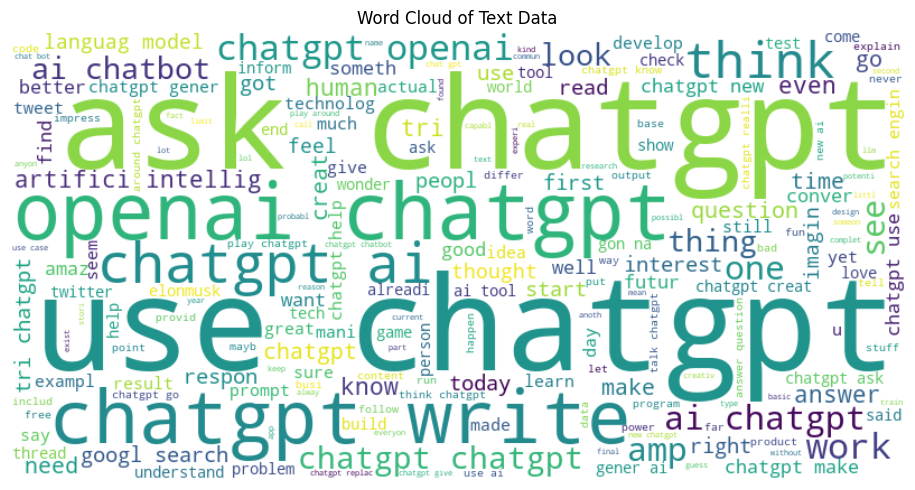

In [14]:
vocab_stats = analyze_text_features(df)
vocab_stats

In [15]:
def analyze_sentiment_distribution(df):
    """
    Analyze the distribution of sentiment labels if available.
    """
    if df["labels"] is None:
        return None
    
    sentiment_stats = {
        'value_counts': df["labels"].value_counts().to_dict(),
        'distribution_percentage': (df["labels"].value_counts(normalize=True) * 100).to_dict()
    }
    
    # Visualize sentiment distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=df["labels"])
    plt.title('Sentiment Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return sentiment_stats

{'value_counts': {'bad': 107796, 'good': 56011, 'neutral': 55487},
 'distribution_percentage': {'bad': 49.155927658759474,
  'good': 25.541510483642966,
  'neutral': 25.30256185759756}}

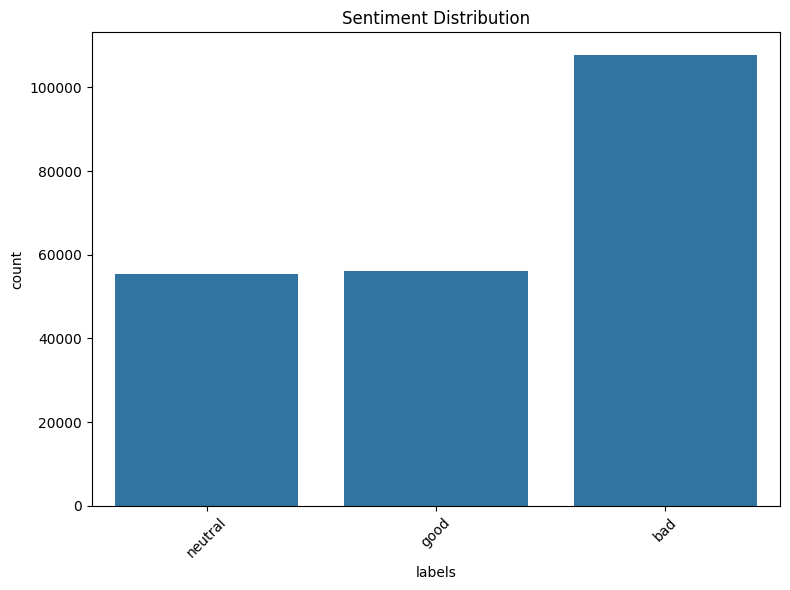

In [16]:
sentiment_stats = analyze_sentiment_distribution(df)
sentiment_stats

In [19]:
def generate_profile_report(df):
    """
    Generate a comprehensive profile report combining all analyses.
    """
    report = {
        'initial_exploration': initial_exploration(df),
        'text_analysis': analyze_text_features(df)
    }
    
    if df["labels"] is not None:
        report['sentiment_analysis'] = analyze_sentiment_distribution(df)
        
    return report

[2025-01-08 01:26:15,898: INFO: 2471696961: Initial exploration completed successfully.]


{'initial_exploration': {'total_rows': 219294,
  'total_columns': 4,
  'dtypes': {'text': dtype('O'),
   'labels': dtype('O'),
   'text_length': dtype('int64'),
   'processed_text': dtype('O')},
  'missing_values': {'text': 0,
   'labels': 0,
   'text_length': 0,
   'processed_text': 0},
  'text_length_stats': {'mean': 144, 'median': 124, 'min': 6, 'max': 357}},
 'text_analysis': {'total_words': 2654672,
  'unique_words': 67858,
  'average_words_per_text': 12.105538683228907,
  'most_common_words': [('chatgpt', 220758),
   ('http', 148016),
   ('ai', 51237),
   ('use', 29535),
   ('openai', 26310),
   ('ask', 21564),
   ('write', 21158),
   ('like', 17192),
   ('googl', 14515),
   ('new', 13616),
   ('get', 11487),
   ('gener', 11424),
   ('code', 11333),
   ('make', 11189),
   ('answer', 10731),
   ('chatbot', 10694),
   ('question', 9570),
   ('think', 9346),
   ('know', 9100),
   ('time', 9022)]},
 'sentiment_analysis': {'value_counts': {'bad': 107796,
   'good': 56011,
   'neutral'

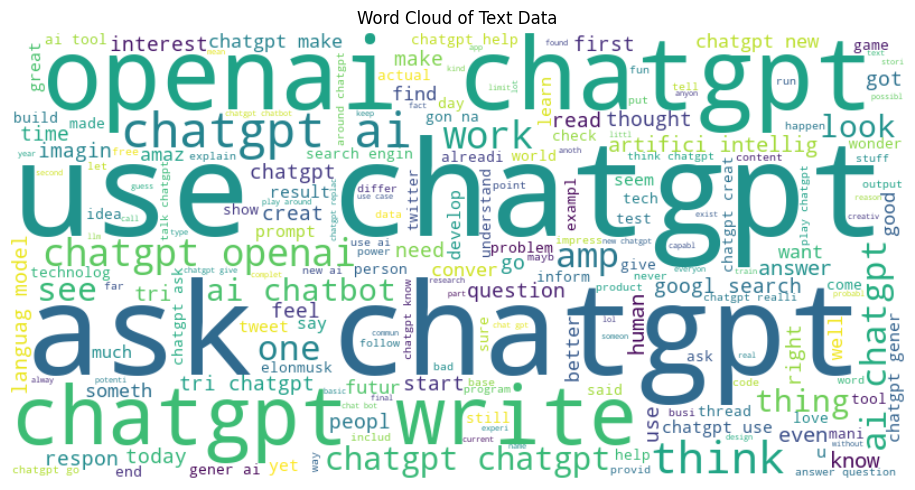

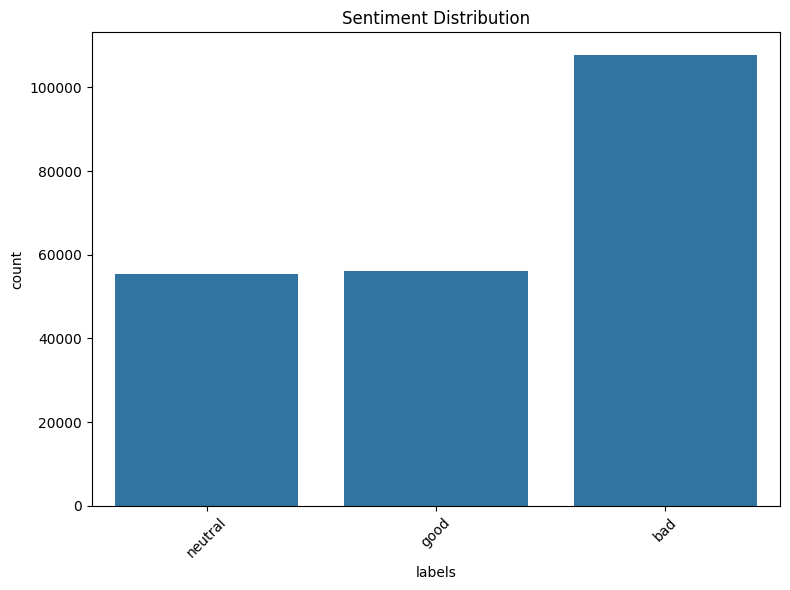

In [20]:
report = generate_profile_report(df)
report

-------------

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
from wordcloud import WordCloud
from typing import Dict, List, Optional, Any
import json
import os
from datetime import datetime
from pathlib import Path
from SentiScope.logging import logger

class SentimentDataProfiler:
    def __init__(self, data_path: str, text_column: str, sentiment_column: Optional[str] = None):
        """
        Initialize the SentimentDataProfiler with a data path and column names.
        
        Parameters:
        data_path (str): Path to the CSV file containing sentiment data
        text_column (str): Name of the column containing text data
        sentiment_column (str, optional): Name of the column containing sentiment labels
        """
        # Convert string path to Path object
        self.path = Path(data_path)
        self.df = self._read_csv_file(self.path)
        self.text_column = text_column
        self.sentiment_column = sentiment_column
        
        # Initialize NLTK components
        try:
            nltk.data.find('tokenizers/punkt')
            nltk.data.find('corpora/stopwords')
        except LookupError:
            logger.info("Downloading required NLTK data...")
            nltk.download('punkt')
            nltk.download('stopwords')
            nltk.download('wordnet')
        
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        
        # Create output directory structure
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.output_dir = Path(os.getcwd()) / 'artifacts' / 'dataprofile' / self.timestamp
        self.output_dir.mkdir(parents=True, exist_ok=True)
        (self.output_dir / 'images').mkdir(exist_ok=True)
        
        # Validate and process
        self._validate_columns()
        self.df['processed_text'] = self.df[self.text_column].apply(self._preprocess_text)

    def _read_csv_file(self, file_path: Path) -> pd.DataFrame:
        """
        Read and validate the CSV file.
        
        Parameters:
        file_path (Path): Path to the CSV file
        
        Returns:
        pd.DataFrame: The loaded DataFrame
        """
        try:
            df = pd.read_csv(file_path)
            logger.info("Successfully read the CSV file.")
            return df
        except FileNotFoundError:
            logger.error(f"Error: File not found at {file_path}")
            raise
        except pd.errors.ParserError:
            logger.error("Error: There might be a parsing issue with the CSV file!")
            try:
                # Attempt to read with more flexible parsing
                df = pd.read_csv(file_path, dtype=str)
                return df
            except Exception as e:
                logger.error(f"Failed to fix parsing errors: {e}")
                raise

    def _validate_columns(self) -> None:
        """Validate that the specified columns exist in the DataFrame."""
        if self.text_column not in self.df.columns:
            raise ValueError(f"Text column '{self.text_column}' not found in DataFrame")
        if self.sentiment_column and self.sentiment_column not in self.df.columns:
            raise ValueError(f"Sentiment column '{self.sentiment_column}' not found in DataFrame")

    def _preprocess_text(self, text: str) -> List[str]:
        """Preprocess a single text string."""
        if not isinstance(text, str):
            return []
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [self.stemmer.stem(token) for token in tokens
                 if token.isalnum() and token not in self.stop_words]
        return tokens

    def _get_initial_statistics(self) -> Dict[str, Any]:
        """Generate basic statistics about the dataset."""
        stats = {
            'total_rows': len(self.df),
            'total_columns': len(self.df.columns),
            'dtypes': {k: str(v) for k, v in self.df.dtypes.to_dict().items()},  # Convert dtypes to strings for JSON
            'missing_values': self.df.isnull().sum().to_dict()
        }

        self.df['text_length'] = self.df[self.text_column].str.len()
        stats['text_length_stats'] = {
            'mean': int(self.df['text_length'].mean()),
            'median': int(self.df['text_length'].median()),
            'min': int(self.df['text_length'].min()),
            'max': int(self.df['text_length'].max())
        }

        return stats

    def _analyze_text_features(self) -> Dict[str, Any]:
        """Analyze text features and generate visualizations."""
        # Get all words from processed texts
        all_words = [word for text in self.df['processed_text'] for word in text]
        word_freq = Counter(all_words)
        
        vocab_stats = {
            'total_words': len(all_words),
            'unique_words': len(word_freq),
            'average_words_per_text': round(len(all_words) / len(self.df), 2),
            'most_common_words': dict(word_freq.most_common(20))
        }
        
        # Generate and save word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Text Data')
        plt.tight_layout()
        plt.savefig(self.output_dir / 'images' / 'wordcloud.png')
        plt.close()
        
        return vocab_stats

    def _analyze_sentiment_distribution(self) -> Optional[Dict[str, Any]]:
        """Analyze sentiment distribution and generate visualization."""
        if not self.sentiment_column:
            return None
        
        sentiment_stats = {
            'value_counts': self.df[self.sentiment_column].value_counts().to_dict(),
            'distribution_percentage': {k: round(v, 2) for k, v in 
                (self.df[self.sentiment_column].value_counts(normalize=True) * 100).to_dict().items()}
        }
        
        # Generate and save sentiment distribution plot
        plt.figure(figsize=(8, 6))
        sns.countplot(data=self.df, x=self.df[self.sentiment_column])
        plt.title('Sentiment Distribution')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(self.output_dir / 'images' / 'sentiment_distribution.png')
        plt.close()
        
        return sentiment_stats

    def generate_report(self) -> str:
        """
        Generate and save a comprehensive profile report.
        
        Returns:
        str: Path to the generated report directory
        """
        # Generate report components
        report = {
            'timestamp': self.timestamp,
            'dataset_info': {
                'text_column': self.text_column,
                'sentiment_column': self.sentiment_column
            },
            'initial_statistics': self._get_initial_statistics(),
            'text_analysis': self._analyze_text_features()
        }
        
        if self.sentiment_column:
            report['sentiment_analysis'] = self._analyze_sentiment_distribution()
        
        # Save report as JSON
        report_path = self.output_dir / 'report.json'
        with open(report_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=4, ensure_ascii=False)
        
        # Generate a README with file descriptions
        readme_content = f"""Data Profile Report
        Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

        Files in this directory:
        1. report.json - Complete analysis report in JSON format
        2. images/wordcloud.png - Word cloud visualization of text data"""

        if self.sentiment_column:
            readme_content += "\n3. images/sentiment_distribution.png - Distribution of sentiment labels"

        with open(self.output_dir / 'README.txt', 'w') as f:
            f.write(readme_content)
        
        return str(self.output_dir)

In [7]:
# Initialize and generate report
profiler = SentimentDataProfiler(
    data_path="artifacts/data_ingestion/file.csv",
    text_column = 'tweets',
    sentiment_column='labels'
)
# Generate report - this will create the dataprofile folder and save everything
report_path = profiler.generate_report()
print(f"Report generated at: {report_path}")

[2025-01-08 01:50:16,268: INFO: 3393158928: Successfully read the CSV file.]
Report generated at: d:\AI\NLP\HandsOn\sentiment-analysis\artifacts\dataprofile\20250108_015016
